In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

import time

from joblib import Parallel, delayed, cpu_count
from matplotlib import cm

In [2]:
def box(x,xlim):
    if x>max(xlim):
        return max(xlim)
    elif x<min(xlim):
        return min(xlim)
    else:
        return x

In [3]:
def projected_gradient_descent(x,t,y_0,M,max_iters_inner,epsilon_1,epsilon_3,alpha_1):
    y=project_to_region(x,y_0,M)
    i=0
    delta=float('inf')
    while delta>epsilon_3 and i<max_iters_inner:
        grad=gradient_g(x,y,t)
        grad_y=grad[1]
        y_old=y
        y-=alpha_1*grad_y
        y=project_to_region(x,y,M)
        delta=y-y_old
        grad_norm=np.abs(grad[1])
        i+=1
        if grad_norm<epsilon_1:
            break
    grad=gradient_g(x,y,t)
    grad_norm=np.abs(grad[1])
    print(f"i: {i}, grad norm: {grad_norm}")
    return float(y),grad_norm<epsilon_1

def LL_solver(x,t,y_0,M,max_iters_inner,epsilon_1,epsilon_3,alpha_1):
    while True:
        y,converged=projected_gradient_descent(x,t,y_0,M,max_iters_inner,epsilon_1,epsilon_3,M*alpha_1)
        if converged:
            return float(y)
        else:
            M/=2
            y_0=y

def barrier_method(x_0,y_0,t,max_iters_outer,M,max_iters_inner,epsilon_1,epsilon_2,alpha_1,alpha_2):
    x=x_0
    y=y_0
    p=0
    grad_norm=float('inf')
    while grad_norm>epsilon_2 and p<max_iters_outer:
        y=LL_solver(x,t,y_0,M,max_iters_inner,epsilon_1,epsilon_3,alpha_1)
        grad_f=gradient_f(x,y)
        grad_f_x=grad_f[0]
        grad_f_y=grad_f[1]
        hessian_y=hessian_y_g(x,y,t)
        mixed_hessian=mixed_hessian_g(x,y,t)
        descent_direction=grad_f_x-mixed_hessian*grad_f_y/hessian_y
        x=x-alpha_2*descent_direction
        x=np.clip(x,0,3)
        grad_norm=np.abs(descent_direction)
        print(f"p: {p}, x: {x}, grad norm of hyperfunction: {grad_norm}")
        p+=1
    return x,y,p

In [4]:
def run_exp(t,max_iters_outer,M,max_iters_inner,epsilon_1,epsilon_2,alpha_1,alpha_2):

    x=np.random.uniform(0,3.5)
    y=np.random.uniform(-5,8.5)
    
    try:
        (x,y,p)=barrier_method(x,y,t,max_iters_outer,M,max_iters_inner,epsilon_1,epsilon_2,alpha_1,alpha_2)
    except OverflowError:
        x=-1
        y=-1
        p=-1

    return x,y,p

# Toy example 1

In [5]:
def f(x,y):
    term1=np.exp(-y+2)/(2+np.cos(4*x))
    term2=0.5*np.log((4*x-2)**2+1)+x**2
    return term1+term2

def gradient_f(x,y):
    term1=np.exp(-y+2)/(2+np.cos(4*x))
    term1_x=term1*(4*np.sin(4*x))/(2+np.cos(4*x))+2*x
    term1_y=-term1

    term2=0.5*np.log((4*x-2)**2+1)
    term2_x=4*(4*x-2)/((4*x-2)**2+1)
    term2_y=0

    df_dx=term1_x+term2_x
    df_dy=term1_y+term2_y

    return np.array([df_dx,df_dy])

def g(x,y,t):
    return (y-2*x)**2-t*np.log(x-y)

def gradient_g(x,y,t):
    dg_dx=-4*(y-2*x)-t/(x-y)
    dg_dy=2*(y-2*x)+t/(x-y)
    return np.array([dg_dx,dg_dy])

def hessian_y_g(x,y,t):
    d2g_dy2=2+t/(x-y)**2
    return d2g_dy2

def mixed_hessian_g(x,y,t):
    d2g_dxdy=-4-t/(x-y)**2
    return d2g_dxdy

def project_to_region(x,y,M):
    if y-x<=-M:
        return y
    else:
        return x-M

In [9]:
n_jobs = cpu_count()
N = 200
t=0.001
max_iters_outer=1000
max_iters_inner=100
M=1
epsilon_1=1e-2
epsilon_2=1e-2
epsilon_3=1e-7
alpha_1=5
alpha_2=0.01
results = Parallel(n_jobs=n_jobs)(delayed(run_exp)(t,max_iters_outer,M,max_iters_inner,epsilon_1,epsilon_2,alpha_1,alpha_2) for i in range(N))

ps = np.array(results)

Text(0.5, 0, 'Number of iterations needed until convergence')

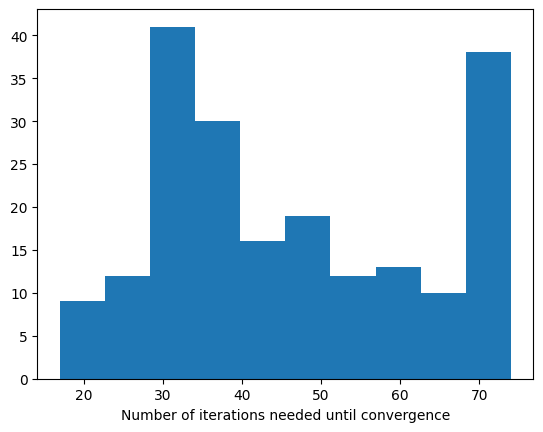

In [10]:
plt.hist(ps[:,2])
plt.xlabel("Number of iterations needed until convergence")

(array([ 2.,  4.,  6.,  8., 10., 12.]),
 [Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6'),
  Text(0, 8.0, '8'),
  Text(0, 10.0, '10'),
  Text(0, 12.0, '12')])

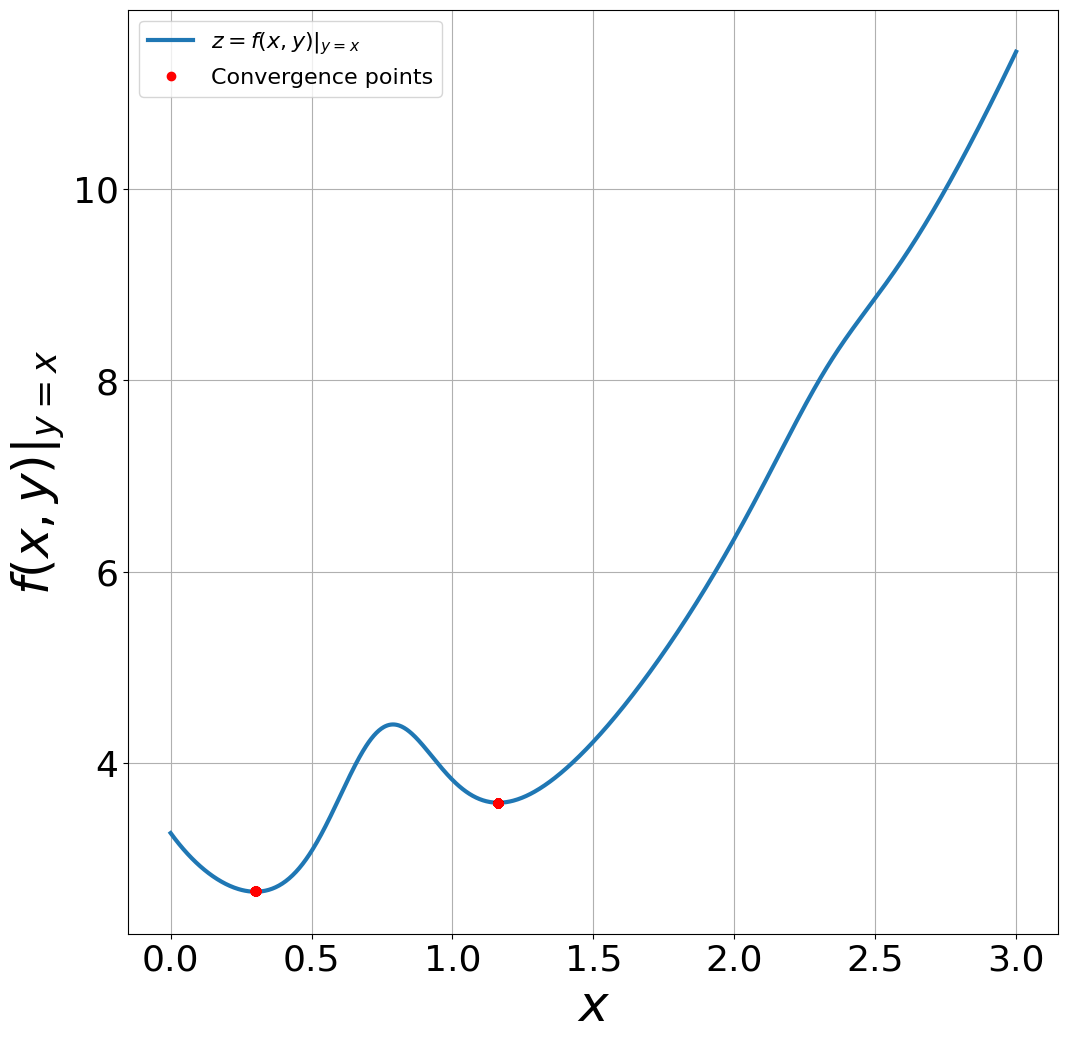

In [11]:
x_ax = np.linspace(0, 3, 1000)

plt.figure(figsize=(12,12))
plt.plot(x_ax, f(x_ax,x_ax), linewidth=3)
for i in range(N):
    plt.plot(ps[i,0], f(ps[i,0], ps[i,1]), 'o', color='r')

plt.legend(['$z=f(x,y)|_{y=x}$', 'Convergence points'], fontsize=16)
plt.grid()
plt.xlabel('$x$', fontsize=36)
plt.ylabel('$f(x,y)|_{y=x}$', fontsize=36)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

Text(0.5, 0.5, '$x$')

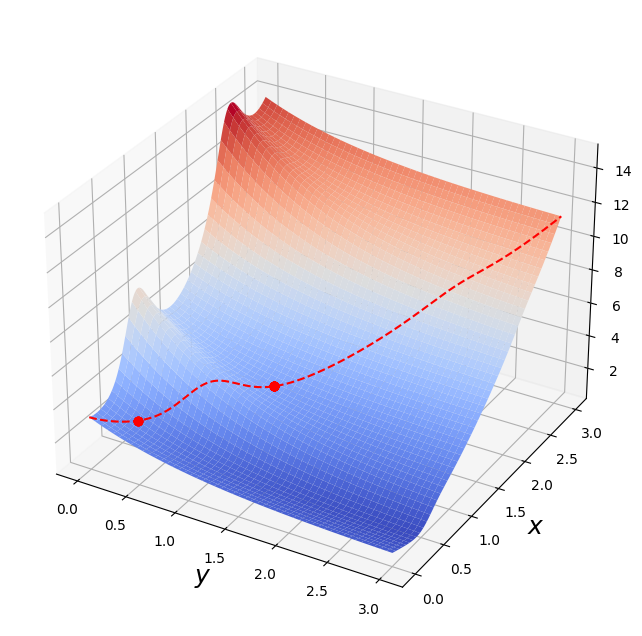

In [12]:
Xx = np.linspace(0,3,1000)
Yy = np.linspace(0,3,1000)
X, Y = np.meshgrid(Xx, Yy)
Z = f(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,8))
surf = ax.plot_surface(Y,X, Z, cmap=cm.coolwarm, alpha=1.)#, rstride=1, cstride=1)

ax.plot(Xx, Xx, f(Xx, Xx), 'r--', zorder=10)

for i in range(n_jobs):
    ax.plot(ps[i,1], ps[i,0], f(ps[i,0], ps[i,1]), 'o', color='r', zorder=10)

ax.set_xlabel("$y$", fontsize=18)
ax.set_ylabel("$x$", fontsize=18)

# Toy example 2

In [13]:
def f(x,y):
    term1=np.exp(-y+2)/(2+np.cos(6*x))
    term2=0.5*np.log((4*x-2)**2+1)
    return term1+term2

def gradient_f(x,y):
    term1=np.exp(-y+2)/(2+np.cos(6*x))
    term1_x=term1*(6*np.sin(6*x))/(2+np.cos(6*x))
    term1_y=-term1

    term2=0.5*np.log((4*x-2)**2+1)
    term2_x=4*(4*x-2)/((4*x-2)**2+1)
    term2_y=0

    df_dx=term1_x+term2_x
    df_dy=term1_y+term2_y

    return np.array([df_dx,df_dy])

def g(x,y,t):
    return (y-2*x)**2-t*np.log(x-y)

def gradient_g(x,y,t):
    dg_dx=-4*(y-2*x)-t/(x-y)
    dg_dy=2*(y-2*x)+t/(x-y)
    return np.array([dg_dx,dg_dy])

def hessian_y_g(x,y,t):
    d2g_dy2=2+t/(x-y)**2
    return d2g_dy2

def mixed_hessian_g(x,y,t):
    d2g_dxdy=-4-t/(x-y)**2
    return d2g_dxdy

def project_to_region(x,y,M):
    if y-x<=-M:
        return y
    else:
        return x-M

In [18]:
n_jobs = cpu_count()
N = 200
t=0.001
max_iters_outer=1000
max_iters_inner=100
M=1
epsilon_1=1e-2
epsilon_2=1e-2
epsilon_3=1e-7
alpha_1=5
alpha_2=0.01
results = Parallel(n_jobs=n_jobs)(delayed(run_exp)(t,max_iters_outer,M,max_iters_inner,epsilon_1,epsilon_2,alpha_1,alpha_2) for i in range(N))

ps = np.array(results)

Text(0.5, 0, 'Number of iterations needed until convergence')

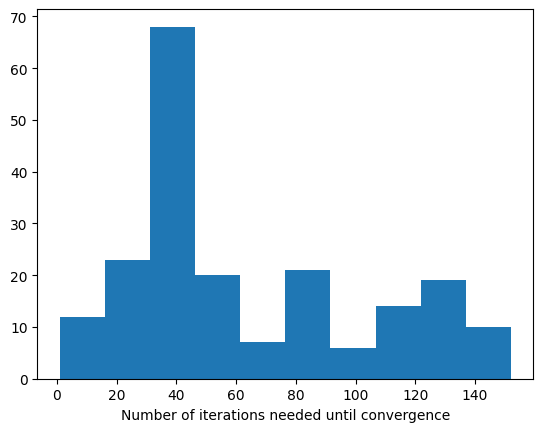

In [19]:
plt.hist(ps[:,2])
plt.xlabel("Number of iterations needed until convergence")

(array([1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 [Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5'),
  Text(0, 3.0, '3.0'),
  Text(0, 3.5, '3.5'),
  Text(0, 4.0, '4.0'),
  Text(0, 4.5, '4.5'),
  Text(0, 5.0, '5.0')])

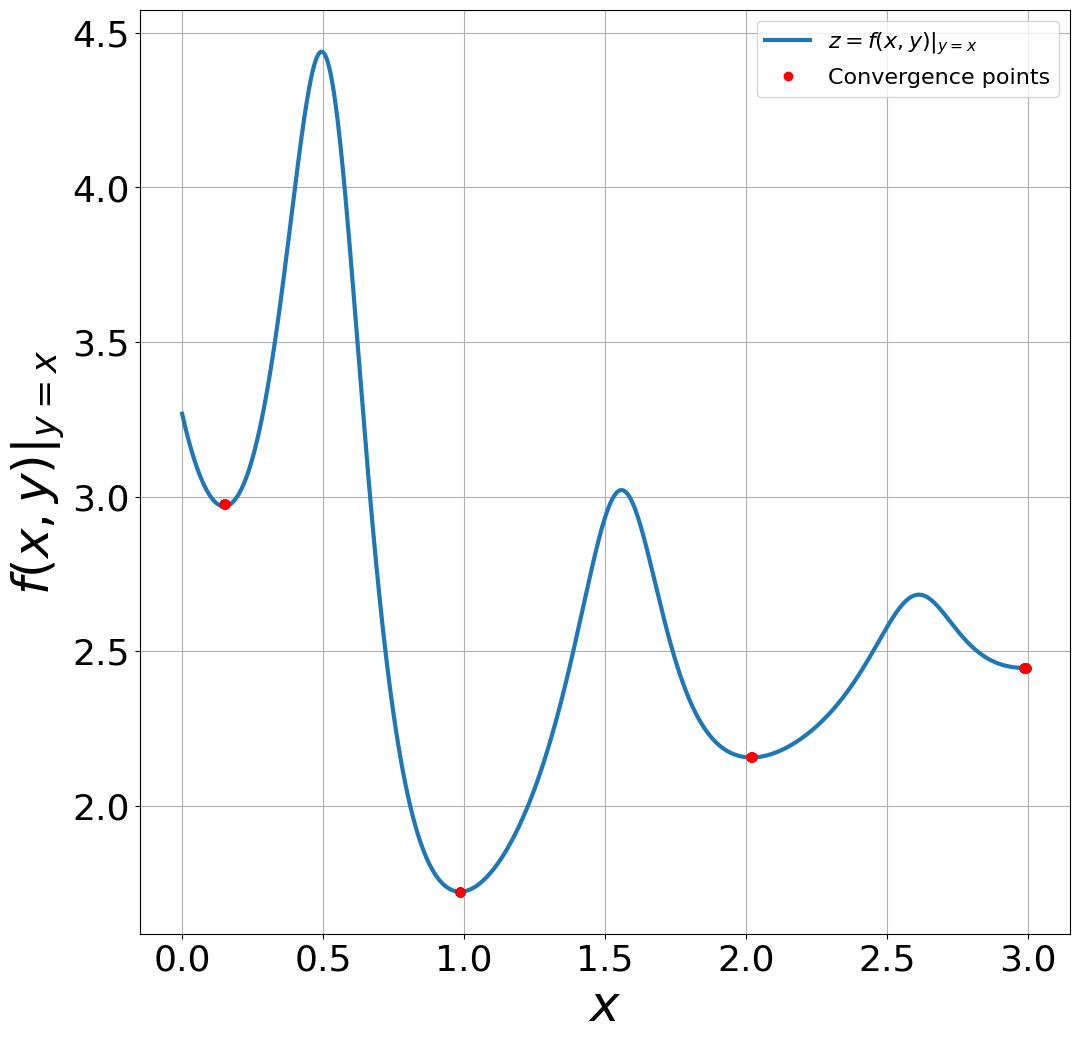

In [20]:
x_ax = np.linspace(0, 3, 1000)

plt.figure(figsize=(12,12))
plt.plot(x_ax, f(x_ax,x_ax), linewidth=3)
for i in range(N):
    plt.plot(ps[i,0], f(ps[i,0], ps[i,1]), 'o', color='r')

plt.legend(['$z=f(x,y)|_{y=x}$', 'Convergence points'], fontsize=16)
plt.grid()
plt.xlabel('$x$', fontsize=36)
plt.ylabel('$f(x,y)|_{y=x}$', fontsize=36)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

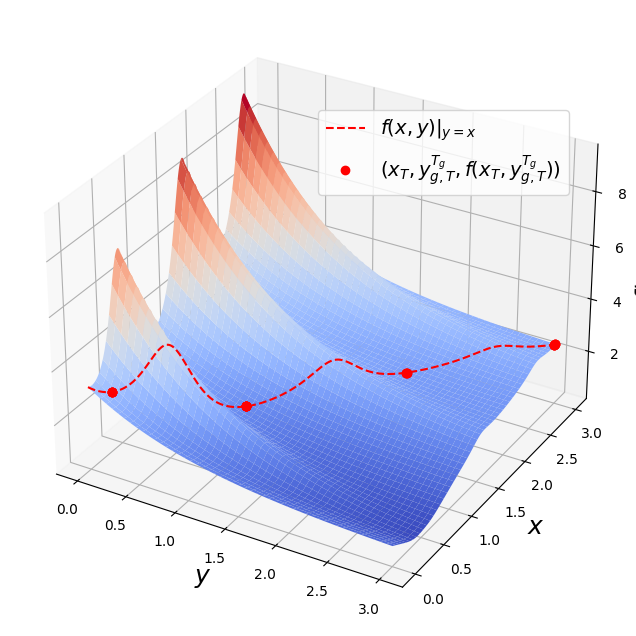

In [21]:
Xx = np.linspace(0,3,1000)
Yy = np.linspace(0,3,1000)
X, Y = np.meshgrid(Xx, Yy)
Z = f(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,8))
surf = ax.plot_surface(Y,X, Z, cmap=cm.coolwarm, alpha=1.)#, rstride=1, cstride=1)

ax.plot(Xx, Xx, f(Xx, Xx), 'r--', zorder=10, label="$f(x,y)|_{y=x}$")

for i in range(n_jobs):
    if i == 1:
        ax.plot(ps[i,1], ps[i,0], f(ps[i,0], ps[i,1]), 'o', color='r', zorder=10, label="$(x_T, y^{T_g}_{g,T}, f(x_T, y^{T_g}_{g,T}))$")
    else:
        ax.plot(ps[i,1], ps[i,0], f(ps[i,0], ps[i,1]), 'o', color='r', zorder=10)

ax.set_xlabel("$y$", fontsize=18)
ax.set_ylabel("$x$", fontsize=18)
ax.set_zlabel("$f(x,y)$", fontsize=18)

ax.legend(loc=(0.5,0.7), fontsize=14)